## Eigengene SVA QTL Info

**Created**: 25 May 2022

## Environment

In [40]:
library(tidyverse)
library(data.table)
library(UpSetR)

setwd("~/eQTL_pQTL_Characterization/")

source("04_Expression/scripts/utils/ggplot_theme.R")

## Load Data

In [2]:
mqtl <- read.csv("~/gains_team282/nikhil/expression/eigengene_sva/all_mqtl.csv")
mqtl.pcs <- read.csv("~/gains_team282/nikhil/expression/eigengene_sva/all_mqtl_all_pcs.csv")

mqtl.sum <- read.table("~/gains_team282/nikhil/expression/eigengene_sva/mqtl_full_summary_statistics_snps.txt", header=T)
mqtl.pcs.sum <- read.table("~/gains_team282/nikhil/expression/eigengene_sva/mqtl_all_pcs_full_summary_statistics_snps.txt", header=T)

map.snps <- read.csv("~/gains_team282/nikhil/expression/eigengene_sva/mqtl_snp_table.csv")

In [3]:
nrow(mqtl)
nrow(mqtl.pcs)

[1] 880

[1] 1966

In [4]:
head(map.snps)

,snps,source,egene,conditional_number,accession
,<chr>,<chr>,<chr>,<int>,<chr>
1,rs3131972,Lead cis-eQTL SNP,ENSG00000237491,NA,NA
2,rs3131972,Lead cis-eQTL SNP,ENSG00000230092,NA,NA
3,rs3131972,Lead cis-eQTL SNP,ENSG00000225880,NA,NA
4,rs2272757,Lead cis-eQTL SNP,ENSG00000188976,NA,NA
5,rs13303327,Lead cis-eQTL SNP,ENSG00000187961,NA,NA
6,rs13303056,Lead cis-eQTL SNP,ENSG00000187583,NA,NA


In [5]:
gene.info <- read.table("/nfs/team282/data/gains_team282/gene_info_864_20412_hla.txt")

In [6]:
head(gene.info)

,seqnames,start,end,width,strand,source,type,score,phase,gene_id,⋯,transcript_source,transcript_biotype,tag,transcript_support_level,exon_number,exon_id,exon_version,protein_id,protein_version,ccds_id
,<chr>,<int>,<int>,<int>,<chr>,<chr>,<chr>,<lgl>,<lgl>,<chr>,⋯,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>
ENSG00000230521,6,29887294,29888268,975,-,havana,gene,NA,NA,ENSG00000230521,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
ENSG00000225864,6,29722981,29723971,991,-,havana,gene,NA,NA,ENSG00000225864,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
ENSG00000227766,6,29942075,29943067,993,-,havana,gene,NA,NA,ENSG00000227766,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
ENSG00000237669,6,30006121,30007116,996,-,havana,gene,NA,NA,ENSG00000237669,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
ENSG00000271581,6,31356647,31357637,991,+,havana,gene,NA,NA,ENSG00000271581,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
ENSG00000285647,6,31367057,31376088,9032,+,havana,gene,NA,NA,ENSG00000285647,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


In [7]:
ebi.studies <- fread("04_Expression/data/gwas_catalog_v1.0.2-studies_r2022-02-21.tsv", header=TRUE, quote="") %>%
    as.data.frame()

In [8]:
head(ebi.studies, n=1)

,DATE ADDED TO CATALOG,PUBMEDID,FIRST AUTHOR,DATE,JOURNAL,LINK,STUDY,DISEASE/TRAIT,INITIAL SAMPLE SIZE,REPLICATION SAMPLE SIZE,PLATFORM [SNPS PASSING QC],ASSOCIATION COUNT,MAPPED_TRAIT,MAPPED_TRAIT_URI,STUDY ACCESSION,GENOTYPING TECHNOLOGY
,<date>,<int>,<chr>,<date>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>
1,2021-08-24,34124712,Sherva R,2021-02-28,Explor Med,www.ncbi.nlm.nih.gov/pubmed/34124712,Genome-wide association study of phenotypes measuring progression from first cocaine or opioid use to dependence reveals novel risk genes.,Cocaine dependence (time to event),"3,554 African American cases, 478 African American controls, 2,712 European ancestry cases, 915 European ancestry controls","572 African American cases, 416 African American controls, 759 European ancestry cases, 1,620 European ancestry controls",Illumina [NR] (imputed),5,cocaine dependence,http://www.ebi.ac.uk/efo/EFO_0002610,GCST012225,Genome-wide genotyping array


In [9]:
modules <- read.csv("~/gains_team282/nikhil/expression/gene_expression/modules.csv") %>%
    dplyr::mutate(Eigengene=gsub("Module_", "ME_", Module))

In [10]:
head(modules)

,Gene,Module,Eigengene
,<chr>,<chr>,<chr>
1,ENSG00000001167,Module_1,ME_1
2,ENSG00000002330,Module_1,ME_1
3,ENSG00000002822,Module_1,ME_1
4,ENSG00000005175,Module_1,ME_1
5,ENSG00000005194,Module_1,ME_1
6,ENSG00000005893,Module_1,ME_1


# Module QTL

First, I ask how many SNPs were significantly associated with any given module. 876 SNPs were associated with at least one module eigengene.

In [11]:
length(unique(mqtl$snp))

[1] 876

Next, how many modules had an association with at least one SNP? 31 modules had an association with at least one SNP.

In [12]:
length(unique(mqtl$me))

[1] 31

How many loci were detected?

In [13]:
length(unique(mqtl.sum$QTL.ID))

[1] 31

How many unique module-locus pairs are there? There are 32.

In [14]:
length(unique(paste0(mqtl.sum$ME, "-", mqtl.sum$QTL.ID)))

[1] 32

What proportion of the module QTL are lead cis-eQTL? Lead conditional cis-eQTL? Trait-associated variants?

In [15]:
merge(mqtl, map.snps, by.x="snp", by.y="snps") %>%
    dplyr::select(snp, source) %>%
    unique() %>%
    dplyr::group_by(source) %>%
    dplyr::summarize(N=n()) %>%
    dplyr::mutate(Prop=N / length(unique(mqtl$snp)))

source,N,Prop
<chr>,<int>,<dbl>
Conditional cis-eQTL SNP,236,0.2694064
EBI GWAS Catalog,657,0.7500000
Lead cis-eQTL SNP,139,0.1586758


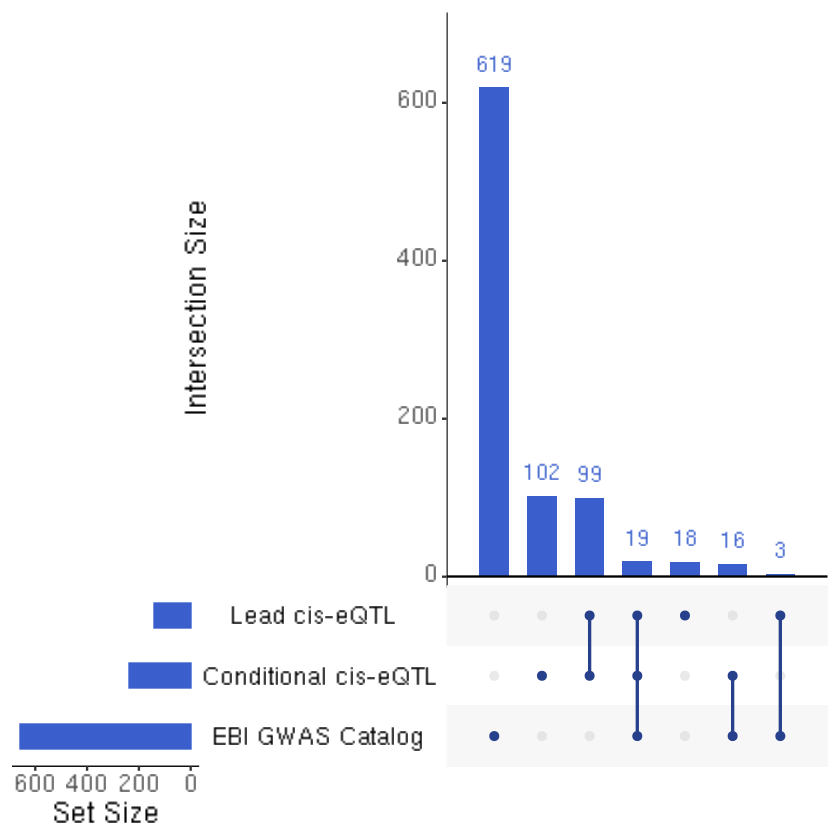

In [44]:
plot.data.df <- merge(mqtl, map.snps, by.x="snp", by.y="snps") %>%
    dplyr::select(snp, source) %>%
    unique()

plot.data <- list()
plot.data[["Lead cis-eQTL"]] <- plot.data.df$snp[plot.data.df$source == "Lead cis-eQTL SNP"]
plot.data[["Conditional cis-eQTL"]] <- plot.data.df$snp[plot.data.df$source == "Conditional cis-eQTL SNP"]
plot.data[["EBI GWAS Catalog"]] <- plot.data.df$snp[plot.data.df$source == "EBI GWAS Catalog"]

upset(
  fromList(plot.data), order.by="freq",
  matrix.color="royalblue4", main.bar.color="royalblue3", sets.bar.color="royalblue3",
  text.scale=2, nsets=3
)

How many of the modules are associated with a cis-eQTL and also contain the corresponding eGene?

In [16]:
merge(mqtl, map.snps, by.x="snp", by.y="snps") %>%
    merge(., modules, by.x="me", by.y="Eigengene") %>%
    dplyr::filter(egene == Gene) %>%
    dplyr::select(me) %>%
    unique() %>%
    nrow()

[1] 28

# Module QTL from All PCs

First, I ask how many SNPs were significantly associated with any given module. 1935 SNPs were associated with at least one module eigengene.

In [17]:
length(unique(mqtl.pcs$snp))

[1] 1935

Next, how many modules had an association with at least one SNP? 48 modules had an association with at least one SNP.

In [18]:
length(unique(mqtl.pcs$me))

[1] 48

A module might have more than one association.

In [19]:
length(unique(mqtl.pcs.sum$QTL.ID))

[1] 76

How many unique module-locus associations are there?

In [20]:
length(unique(paste0(mqtl.pcs.sum$ME, "-", mqtl.pcs.sum$QTL.ID)))

[1] 76

What proportion of the module QTL are lead cis-eQTL? Lead conditional cis-eQTL? Trait-associated variants?

In [21]:
merge(mqtl.pcs, map.snps, by.x="snp", by.y="snps") %>%
    dplyr::select(snp, source) %>%
    unique() %>%
    dplyr::group_by(source) %>%
    dplyr::summarize(N=n()) %>%
    dplyr::mutate(Prop=N / length(unique(mqtl.pcs$snp)))

source,N,Prop
<chr>,<int>,<dbl>
Conditional cis-eQTL SNP,486,0.2511628
EBI GWAS Catalog,1479,0.7643411
Lead cis-eQTL SNP,292,0.1509044


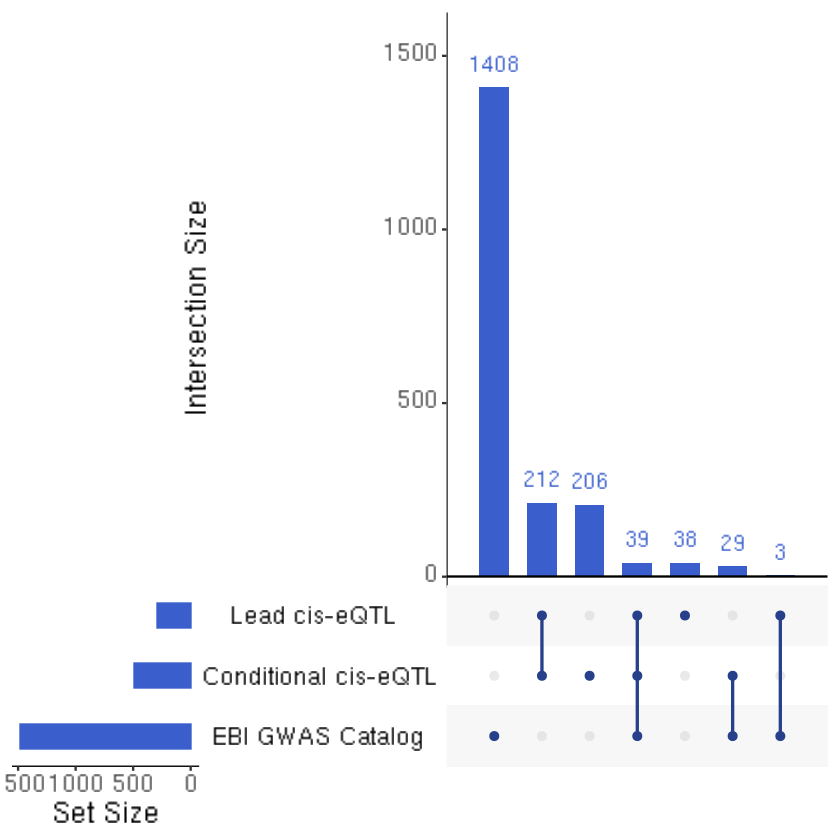

In [45]:
plot.data.df <- merge(mqtl.pcs, map.snps, by.x="snp", by.y="snps") %>%
    dplyr::select(snp, source) %>%
    unique()

plot.data <- list()
plot.data[["Lead cis-eQTL"]] <- plot.data.df$snp[plot.data.df$source == "Lead cis-eQTL SNP"]
plot.data[["Conditional cis-eQTL"]] <- plot.data.df$snp[plot.data.df$source == "Conditional cis-eQTL SNP"]
plot.data[["EBI GWAS Catalog"]] <- plot.data.df$snp[plot.data.df$source == "EBI GWAS Catalog"]

upset(
  fromList(plot.data), order.by="freq",
  matrix.color="royalblue4", main.bar.color="royalblue3", sets.bar.color="royalblue3",
  text.scale=2, nsets=3
)

How many of the modules are associated with a cis-eQTL and also contain the corresponding eGene?

In [22]:
merge(mqtl.pcs, map.snps, by.x="snp", by.y="snps") %>%
    merge(., modules, by.x="me", by.y="Eigengene") %>%
    dplyr::filter(egene == Gene) %>%
    dplyr::select(me) %>%
    unique() %>%
    nrow()

[1] 45

How many associations did we lose by decreasing the threshold? Lost 13 SNP-module pairs. Lost one module - module 14.

In [39]:
length(setdiff(paste0(mqtl$snp, "-", mqtl$me), paste0(mqtl.pcs$snp, "-", mqtl.pcs$me)))

[1] 13

In [37]:
setdiff(mqtl$me, mqtl.pcs$me)

[1] "ME_14"

In [23]:
ebi.snps <- merge(mqtl.pcs, map.snps, by.x="snp", by.y="snps") %>%
    dplyr::filter(source == "EBI GWAS Catalog") %>%
    dplyr::select(snp, me, accession) %>%
    merge(., ebi.studies, by.x="accession", by.y="STUDY ACCESSION")

write.csv(ebi.snps, "~/gains_team282/nikhil/expression/eigengene_sva/mqtl_all_pcs_ebi_snps.csv")

In [24]:
snp.info <- merge(mqtl.pcs, map.snps, by.x="snp", by.y="snps") %>%
    merge(., gene.info %>% dplyr::select(gene_id, gene_name), by.x="egene", by.y="gene_id", all.x=T) %>%
    merge(., modules %>% dplyr::select(Gene, Module), by.x="egene", by.y="Gene", all.x=T) %>%
    dplyr::select(me, pc, snp, chr, pos, minor, major, source, egene, conditional_number, gene_name, module=Module) %>%
    dplyr::arrange(me, snp)

write.csv(snp.info, "~/gains_team282/nikhil/expression/eigengene_sva/mqtl_all_pcs_snp_info.csv", row.names=F)